# Model 4: using mixed data (satellite imagery and structured data) to predict where the mosts serious traffic accidents will happen

This notebook builds on the previous one. It applies the model architecture constructed in model 3 to a new dataset of satellite images of areas where the most serious (serious and fatal) accidents occurred, in order to predict the locations of the most serious traffic accidents.

## Obtaining and preparing the data

### Importing the data

In [105]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
from scipy.spatial import cKDTree
np.random.seed(123)
from shapely.ops import nearest_points
import geopandas
from math import *
import urllib, os
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import MinMaxScaler
import glob
import cv2

from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Input, concatenate

from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, RMSprop
import argparse
import locale

from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from keras import regularizers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.models import load_model

In [48]:
accidents = pd.read_csv('data/modelling/London_accidents_merged.csv')
accidents.head()

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,2nd_Road_Class,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Hour,Two_Hour_Groupings,Time_of_Day,Was_Daylight,Was_Bad_Weather,Was_Road_Dry,log_Number_of_Casualties,log_Number_of_Vehicles,LSOA,population_per_hectare,bicycle_aadf,motorbike_aadf,car_aadf,bus_aadf,light_goods_vehicle_aadf,heavy_goods_vehicle_aadf,Road,RCat
0,201301BS70003,-0.171402,51.486361,Serious,2,1,2013-01-02,Wednesday,A,Single carriageway,30.0,T or staggered junction,Unclassified,Daylight,Fine no high winds,Dry,Urban,9,8am-10am,Morning,Yes,No,Yes,0.000000,0.693147,E01002844,110.8,1634.4,860.4,14888.0,1139.8,2297.0,352.0,A3217,PA
1,201301BS70005,-0.173356,51.495115,Slight,1,2,2013-01-04,Friday,A,Single carriageway,30.0,Crossroads,A,Daylight,Other,Dry,Urban,8,8am-10am,Morning,Yes,Yes,Yes,0.693147,0.000000,E01002821,74.6,559.6,1516.0,28505.6,1396.2,3868.6,1003.0,A4,PA
2,201301BS70006,-0.210767,51.518353,Slight,1,1,2013-01-07,Monday,B,Single carriageway,30.0,Crossroads,B,Daylight,Fine no high winds,Dry,Urban,11,10am-12pm,Office hours,Yes,No,Yes,0.000000,0.000000,E01002878,133.4,2.6,3898.2,63274.8,763.4,15253.6,3185.8,A40,PA
3,201301BS70007,-0.209675,51.516808,Slight,2,1,2013-01-10,Thursday,B,Single carriageway,30.0,Crossroads,C,Daylight,Fine no high winds,Dry,Urban,10,10am-12pm,Office hours,Yes,No,Yes,0.000000,0.693147,E01002831,179.2,2.6,3898.2,63274.8,763.4,15253.6,3185.8,A40,PA
4,201301BS70009,-0.194332,51.492922,Slight,2,1,2013-01-04,Friday,A,One way street,30.0,T or staggered junction,Unclassified,Darkness - lights lit,Fine no high winds,Dry,Urban,17,4pm-6pm,Rush hour,No,No,Yes,0.000000,0.693147,E01002851,272.3,869.2,1229.8,20478.6,897.2,4951.6,1251.4,A3220,PA


In [49]:
# This additional dataframe contains the latitude and longitude centre points for each LSOA
lsoa_latlong = pd.read_csv('data/geography/UK_LSOA_bounding_boxes.csv', usecols=['lsoa', 'Latitude', 'Longitude'])
lsoa_latlong.head()

,lsoa,Latitude,Longitude
0,E01000001,51.520269,-0.0950
1,E01000001,51.519848,-0.0967
2,E01000001,51.519030,-0.0962
3,E01000001,51.516904,-0.0981
4,E01000003,51.522376,-0.0973


In [50]:
population = pd.read_csv('data/population/Population_density.csv')
population.head()

,LSOA,population_per_hectare
0,E01012334,0.4
1,E01012335,12.1
2,E01012366,0.3
3,E01033481,9.3
4,E01033482,6.9


In [51]:
traffic = pd.read_csv('data/traffic/Traffic_averages.csv')
traffic.head()

,CP,S Ref Latitude,S Ref Longitude,bicycle_aadf,motorbike_aadf,car_aadf,bus_aadf,light_goods_vehicle_aadf,heavy_goods_vehicle_aadf
0,51,49.915023,-6.317073,238.2,96.8,539.4,27.0,379.0,40.4
1,52,49.912343,-6.305686,87.4,79.4,629.0,9.0,221.8,11.0
2,53,49.917141,-6.306114,181.8,142.6,777.2,32.2,403.8,29.4
3,54,49.917810,-6.298996,61.2,54.8,342.8,6.0,251.6,34.4
4,55,49.918585,-6.295094,33.6,20.8,165.6,0.0,150.8,15.2


In [52]:
# Combining the motor vehicle traffic columns, based on the multi-collinearity found in model 1
to_sum = ['motorbike_aadf', 'car_aadf', 'bus_aadf', 'light_goods_vehicle_aadf', 'heavy_goods_vehicle_aadf']
traffic['motor_vehicle_aadf'] = traffic[to_sum].sum(axis=1)
traffic.drop(to_sum, axis=1, inplace=True)
traffic.head()

,CP,S Ref Latitude,S Ref Longitude,bicycle_aadf,motor_vehicle_aadf
0,51,49.915023,-6.317073,238.2,1082.6
1,52,49.912343,-6.305686,87.4,950.2
2,53,49.917141,-6.306114,181.8,1385.2
3,54,49.917810,-6.298996,61.2,689.6
4,55,49.918585,-6.295094,33.6,352.4


### Creating the dataset of 'danger' locations (with traffic accidents)

In [53]:
def myround(x, base=.0005):
    return base * round(x/base)

In [54]:
# Adding rounded lat and long columns and a grid square column to the London accident dataset
accidents['lat_4dp'] = myround(accidents['Latitude'])
accidents['long_4dp'] = myround(accidents['Longitude'])
accidents['grid_square'] = round(accidents['lat_4dp'],4).map(str) + "," + round(accidents['long_4dp'],4).map(str)

In [55]:
# Get just accidents that are serious/fatal and drop duplicates based on grid_square
serious_fatal_accidents = accidents[accidents['Accident_Severity']!='Slight'].drop_duplicates(['grid_square'])

In [56]:
# Take random sample of 10000 serious/fatal accidents
serious_fatal_accidents_sample = serious_fatal_accidents.sample(n=10000, random_state=42, 
                                                                replace=False).drop_duplicates(['grid_square'])
print(len(serious_fatal_accidents_sample))
serious_fatal_accidents_sample.head()

10000


,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,2nd_Road_Class,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Hour,Two_Hour_Groupings,Time_of_Day,Was_Daylight,Was_Bad_Weather,Was_Road_Dry,log_Number_of_Casualties,log_Number_of_Vehicles,LSOA,population_per_hectare,bicycle_aadf,motorbike_aadf,car_aadf,bus_aadf,light_goods_vehicle_aadf,heavy_goods_vehicle_aadf,Road,RCat,lat_4dp,long_4dp,grid_square
1602,201301CW10782,-0.178017,51.511914,Serious,2,1,2013-06-23,Sunday,Unclassified,Single carriageway,30.0,T or staggered junction,Unclassified,Darkness - lights lit,Fine no high winds,Dry,Urban,3,2am-4am,Night,No,No,Yes,0.0,0.693147,E01004694,177.2,1434.4,1700.6,23408.2,1297.4,5069.8,700.4,A402,PA,51.512,-0.1780,"51.512,-0.178"
66680,201501KF60668,0.035556,51.534803,Serious,1,1,2015-09-05,Saturday,B,Single carriageway,30.0,T or staggered junction,Unclassified,Daylight,Fine no high winds,Dry,Urban,19,6pm-8pm,Evening,Yes,No,Yes,0.0,0.000000,E01003491,190.8,29.8,4.2,296.8,0.8,32.8,3.0,U,MCU,51.535,0.0355,"51.535,0.0355"
16842,201301TX20552,-0.373621,51.458227,Serious,2,1,2013-09-20,Friday,A,Single carriageway,30.0,T or staggered junction,Unclassified,Daylight,Fine no high winds,Dry,Urban,16,4pm-6pm,Rush hour,Yes,No,Yes,0.0,0.693147,E01002652,91.5,176.8,146.2,13306.4,383.2,1689.0,363.2,A314,PA,51.458,-0.3735,"51.458,-0.3735"
41291,201401PY20786,0.109107,51.387763,Serious,1,1,2014-10-31,Friday,A,Single carriageway,30.0,Crossroads,C,Daylight,Fine no high winds,Dry,Urban,19,6pm-8pm,Evening,Yes,No,Yes,0.0,0.000000,E01000722,28.3,35.4,292.0,23168.0,633.2,3761.8,1040.0,A224,PA,51.388,0.1090,"51.388,0.109"
87227,2016010000752,-0.095963,51.582192,Serious,1,1,2016-11-08,Tuesday,Unclassified,Single carriageway,20.0,Not at junction or within 20 meters,Not at junction or within 20 meters,Daylight,Fine no high winds,Dry,Urban,9,8am-10am,Morning,Yes,No,Yes,0.0,0.000000,E01002042,60.4,264.8,229.4,13171.8,966.4,2134.8,305.4,A504,PA,51.582,-0.0960,"51.582,-0.096"


In [57]:
# Create model 4 dataset just consisting of traffic and population features
# Keep location features to get safe grid squares later
danger_squares = serious_fatal_accidents_sample[['Latitude', 'Longitude', 'population_per_hectare', 'bicycle_aadf', 
                                'motorbike_aadf', 'car_aadf', 'bus_aadf', 'light_goods_vehicle_aadf', 
                                'heavy_goods_vehicle_aadf', 'lat_4dp', 'long_4dp', 'grid_square']]

In [58]:
# Combine traffic features for motor vehicles like we did in model 1 notebook
to_sum = ['motorbike_aadf', 'car_aadf', 'bus_aadf', 'light_goods_vehicle_aadf', 'heavy_goods_vehicle_aadf']
danger_squares['motor_vehicle_aadf'] = danger_squares[to_sum].sum(axis=1)
danger_squares.drop(to_sum, axis=1, inplace=True)

C:\Users\Laura\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Laura\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [59]:
# Getting columns in the right order
danger_squares = danger_squares[['grid_square', 'Latitude', 'Longitude', 'population_per_hectare', 
                                 'bicycle_aadf', 'motor_vehicle_aadf']]

# Rename columns for merging with safe dataset
danger_squares = danger_squares.rename(columns={'Latitude': 'latitude', 'Longitude': 'longitude'})

# Add safe column of all 0's due to being danger dataset
danger_squares['safe'] = 0

In [86]:
danger_squares.set_index('grid_square', inplace=True)
danger_squares.head()

,latitude,longitude,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
grid_square,,,,,,
"51.512,-0.178",51.511914,-0.178017,177.2,1434.4,32176.4,0
"51.535,0.0355",51.534803,0.035556,190.8,29.8,337.6,0
"51.458,-0.3735",51.458227,-0.373621,91.5,176.8,15888.0,0
"51.388,0.109",51.387763,0.109107,28.3,35.4,28895.0,0
"51.582,-0.096",51.582192,-0.095963,60.4,264.8,16807.8,0


In [33]:
# save dataset for model 4 notebook
#danger_squares.to_csv('model4_danger_dataset.csv')

In [61]:
# Creating a list of danger squares to download using Google Static Maps API
model4_danger_squares = list(danger_squares.grid_square)

### Getting the dataset of 'safe' locations (with no accidents)

The same dataset of safe squares will be used from model 3.

In [90]:
# Importing the same safe squares dataset (with no accidents) as was used in model 3
safe_squares = pd.read_csv('data/modelling/model3_safe_dataset.csv')
safe_squares.set_index('grid_square', inplace=True)
safe_squares.head()

,latitude,longitude,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
grid_square,,,,,,
"51.572,-0.4435",51.572,-0.4435,31.1,151.8,25847.8,1
"51.407,-0.1835",51.407,-0.1835,142.5,575.0,35016.4,1
"51.468,0.2515",51.468,0.2515,1.5,0.0,128692.0,1
"51.319,-0.286",51.319,-0.2860,4.0,85.2,16208.4,1
"51.341,0.196",51.341,0.1960,2.0,16.4,5928.4,1


### Combining the datasets of safe and danger squares

In [26]:
# Creating the final dataset containing safe and danger squares
df = safe_squares.append(danger_squares)
len(df)

20000

In [28]:
df.drop(['latitude', 'longitude'], axis=1, inplace=True)
df.head()

,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
grid_square,,,,
"51.572,-0.4435",31.1,151.8,25847.8,1
"51.407,-0.1835",142.5,575.0,35016.4,1
"51.468,0.2515",1.5,0.0,128692.0,1
"51.319,-0.286",4.0,85.2,16208.4,1
"51.341,0.196",2.0,16.4,5928.4,1


In [29]:
df.to_csv('data/modelling/model4_dataset.csv')

## Example images from the serious/fatal class

The images below show the first five satellite images of areas where serious or fatal accidents occurred. They are primarily large motorways (highways) with multiple lanes, on straight sections of road. This is expected based on the results of the EDA of serious and fatal accidents in notebook 3.

In [109]:
def show_image(image_path, size=[600, 400]):
    img = load_img(image_path, target_size=(size[0], size[1]))
    img_tensor = img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    plt.imshow(img_tensor[0])

In [102]:
imgs_danger_path = 'model4_images/fatal_or_serious'
imgs_danger = [file for file in os.listdir(imgs_danger_path) if file.endswith('.jpg')]

imgs_danger_plot = []
for img in imgs_danger[:5]:
    imgs_danger_plot.append(os.path.join(imgs_danger_path, img))

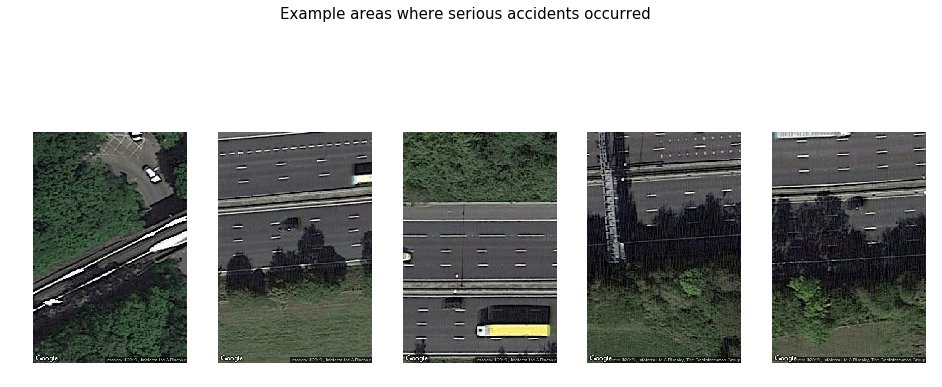

In [111]:
fig = plt.figure(figsize=(16,7))
for i, img in enumerate(imgs_danger_plot):
    fig.add_subplot(1,5,i+1)
    plt.suptitle('Example areas where serious accidents occurred', fontsize=15)
    show_image(img)
    plt.axis('off')

## Modelling

### Model iteration 1

The lists of grid squares from the safe and serious square sets were used to download images from the Google Static Maps API using the same code described in notebook 2, into a folder called 'model4_images'.

The same model structure will be used as the best model produced for model 3 (version 3), in order to compare performance.

In [30]:
# Getting images and reshaping
image_folder = 'model4_images/'
image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        image_folder, shuffle=False, class_mode='binary',
        target_size=(128, 128), batch_size=20000)

Found 20000 images belonging to 2 classes.


In [31]:
# Checking the labels
image_generator.class_indices

{'fatal_or_serious': 0, 'safe': 1}

In [32]:
images, labels = next(image_generator)

In [33]:
# Getting the ordered list of filenames for the images
image_files = pd.Series(image_generator.filenames)
image_files = image_files.str.split("\\", expand=True)[1].str[:-4]
image_files = list(image_files)

In [34]:
# Sorting the structured data into the same order as the images
df_sorted = df.reindex(image_files)

Double checking the dataframe is in the same order as the images:

In [35]:
df_sorted.head(1)

,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
grid_square,,,,
"51.257,-0.5345",19.6,45.6,11395.6,0


This image is for the correct grid square, confirming that the dataframe is in the correct order.

Text(0.5, 1.0, 'Ground Truth : 0.0')

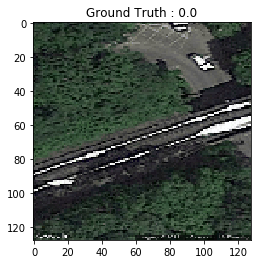

In [36]:
plt.imshow(images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(labels[0]))

The following functions will be used to pre-process the data and create the mixed-input neural network architecture.

In [37]:
def process_structured_data(df, train, test):
    """
    Pre-processes the given dataframe by minmaxscaling the continuous features (fit-transforming the training data and transforming the test data)
    """
    continuous = ["population_per_hectare", "bicycle_aadf", "motor_vehicle_aadf"]
    cs = MinMaxScaler()
    trainX = cs.fit_transform(train[continuous])
    testX = cs.transform(test[continuous])
    return (trainX, testX)

In [38]:
def create_mlp(dim, regularizer=None):
    """Creates a simple two-layer MLP with inputs of the given dimension"""
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu", kernel_regularizer=regularizer))
    model.add(Dense(4, activation="relu", kernel_regularizer=regularizer))
    return model

In [39]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regularizer=None):
    """
    Creates a CNN with the given input dimension and filter numbers.
    Adapted from the function described here: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
    """
    # Initialize the input shape and channel dimension, where the number of channels is the last dimension
    inputShape = (height, width, depth)
    chanDim = -1
 
    # Define the model input
    inputs = Input(shape=inputShape)
 
    # Loop over the number of filters 
    for (i, f) in enumerate(filters):
        # If this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs
 
        # Create loops of CONV => RELU => BN => POOL layers
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
    # Final layers - flatten the volume, then Fully-Connected => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16, kernel_regularizer=regularizer)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
 
    # Apply another fully-connected layer, this one to match the number of nodes coming out of the MLP
    x = Dense(4, kernel_regularizer=regularizer)(x)
    x = Activation("relu")(x)
 
    # Construct the CNN
    model = Model(inputs, x)
 
    # Return the CNN
    return model        

The following functions will be used for evaluation:

In [40]:
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    """Plots a confusion matrix"""
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

In [41]:
def cnn_evaluation(model, history, train_features, train_images, train_labels, test_features, test_images, test_labels, class_names=None, model_name=None):
    """
    Evaluates the performance of a CNN with loss and accuracy plots, a confusion matrix and a classification report for the training and test sets.
    """
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epch = range(1, len(train_acc) + 1)
    plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
    plt.plot(epch, val_acc, 'g', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epch, train_loss, 'r.', label='Training loss')
    plt.plot(epch, val_loss, 'r', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    results_test = model.evaluate([test_features, test_images], test_labels)
    print('Test Loss:', results_test[0])
    print('Test Accuracy:', results_test[1])
    
    y_train_pred = np.round(model.predict([train_features, train_images]))
    y_pred = np.round(model.predict([test_features, test_images]))
    
    show_cf(test_labels, y_pred, class_names=class_names, model_name=model_name)
    
    print(classification_report(train_labels, y_train_pred))
    print(classification_report(test_labels, y_pred))

**Conducting the train test split:**

In [42]:
# Using train_test_split to partition the training and testing structured data attributes and images
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(df_sorted, images, test_size=0.25, random_state=42)

In [43]:
# Setting the labels for y as the safe column
trainY = trainAttrX["safe"]
testY = testAttrX["safe"]

In [44]:
# Process the structured data
(trainAttrX, testAttrX) = process_structured_data(df_sorted, trainAttrX, testAttrX)

**Building the model:**

In [45]:
# Create the MLP and CNN models
mlp1 = create_mlp(trainAttrX.shape[1], regularizer=regularizers.l1(0.005))
cnn1 = create_cnn(128, 128, 3, regularizer=regularizers.l1(0.005))
 
# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = concatenate([mlp1.output, cnn1.output])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [46]:
print(mlp1.summary())
print(cnn1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
Total params: 68
Trainable params: 68
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
batch_nor

In [47]:
# The final FC layer head will have two dense layers
x = Dense(4, activation="relu", kernel_regularizer=regularizers.l1(0.005))(combinedInput)
x = Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l1(0.005))(x)

In [48]:
start = datetime.datetime.now()

model1 = Model(inputs=[mlp1.input, cnn1.input], outputs=x)

# compile the model 
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model1.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=opt)
 
# train the model, and validate with the first 1000 rows of the test set
model1_history = model1.fit([trainAttrX, trainImagesX], trainY, validation_data=([testAttrX[:1000], testImagesX[:1000]], testY[:1000]), epochs=15, batch_size=10)
 
end = datetime.datetime.now()
print("Time taken to run:", end-start)

Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 1000 samples
Epoch 1/15
15000/15000 [==============================] - 260s 17ms/step - loss: 2.3789 - acc: 0.6644 - val_loss: 2.1511 - val_acc: 0.5760
Epoch 2/15
15000/15000 [==============================] - 248s 17ms/step - loss: 2.2179 - acc: 0.7141 - val_loss: 2.0828 - val_acc: 0.6090
Epoch 3/15
15000/15000 [==============================] - 246s 16ms/step - loss: 1.9079 - acc: 0.7405 - val_loss: 1.9008 - val_acc: 0.6660
Epoch 4/15
15000/15000 [==============================] - 247s 16ms/step - loss: 1.9692 - acc: 0.7437 - val_loss: 1.4437 - val_acc: 0.7680
Epoch 5/15
15000/15000 [==============================] - 248s 17ms/step - loss: 1.7485 - acc: 0.7647 - val_loss: 1.3878 - val_acc: 0.7870
Epoch 6/15
15000/15000 [==============================] - 246s 16ms/step - loss: 1.5961 - acc: 0.7779 - val_loss: 1.8886 - val_acc: 0.7740
Epoch 7/15
15000/15000 [==============================] - 246s 16ms/s

In [49]:
model1.save('models/mixed_model4_v1.h5')

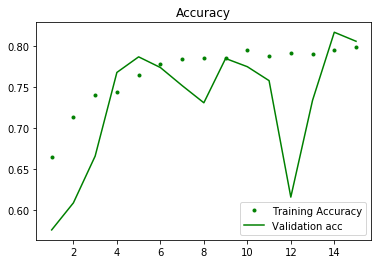

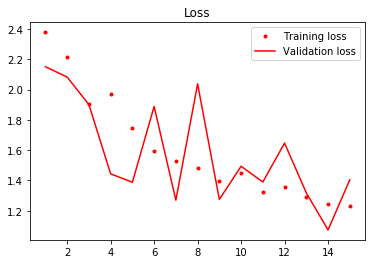

4000/4000 [==============================] - 28s 7ms/step
Test Loss: 1.4014118785858154
Test Accuracy: 0.81675
              precision    recall  f1-score   support

           0       0.79      0.89      0.83      7476
           1       0.87      0.76      0.81      7524

   micro avg       0.82      0.82      0.82     15000
   macro avg       0.83      0.82      0.82     15000
weighted avg       0.83      0.82      0.82     15000

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      2013
           1       0.86      0.76      0.80      1987

   micro avg       0.82      0.82      0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



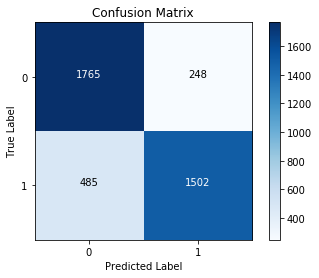

In [52]:
cnn_evaluation(model1, model1_history, trainAttrX, trainImagesX, trainY, testAttrX[1000:], testImagesX[1000:], testY[1000:], class_names=['serious/fatal', 'safe'])

This model is performing well, with an average F1 score of 0.82 (better than the best version of model 3, which scored 0.80). There is no overfitting, and there is a particularly low number of false negatives, which is preferred.

### Model iteration 2

As one final version, this iteration of the model will add an extra layer to the MLP branch of the neural network, as it is currently only one small layer and an output layer. It will also be run for slightly more epochs.

In [83]:
# Getting images and reshaping
image_folder = 'model4_images/'
image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        image_folder, shuffle=False, class_mode='binary',
        target_size=(128, 128), batch_size=20000)

Found 20000 images belonging to 2 classes.


In [76]:
# Checking the labels
image_generator.class_indices

{'fatal_or_serious': 0, 'safe': 1}

In [84]:
images, labels = next(image_generator)

In [85]:
# Getting the ordered list of filenames for the images
image_files = pd.Series(image_generator.filenames)
image_files = image_files.str.split("\\", expand=True)[1].str[:-4]
image_files = list(image_files)

In [86]:
# Sorting the structured data into the same order as the images
df_sorted = df.reindex(image_files)

In [87]:
# Adding an extra layer to the 'create MLP' function
def create_mlp(dim, regularizer=None):
    """Creates a three-layer MLP with inputs of the given dimension"""
    model = Sequential()
    model.add(Dense(16, input_dim=dim, activation="relu", kernel_regularizer=regularizer))
    model.add(Dense(32, input_dim=dim, activation="relu", kernel_regularizer=regularizer))
    model.add(Dense(4, activation="relu", kernel_regularizer=regularizer))
    return model

In [88]:
# Create the MLP and CNN models
mlp2 = create_mlp(trainAttrX.shape[1], regularizer=regularizers.l1(0.005))
cnn2 = create_cnn(128, 128, 3, regularizer=regularizers.l1(0.005))
 
# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = concatenate([mlp2.output, cnn2.output])

In [89]:
print(mlp2.summary())
print(cnn2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_22 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 132       
Total params: 740
Trainable params: 740
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
activat

In [90]:
# The final FC layer head will have two dense layers
x = Dense(4, activation="relu", kernel_regularizer=regularizers.l1(0.005))(combinedInput)
x = Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l1(0.005))(x)

In [91]:
model2 = Model(inputs=[mlp2.input, cnn2.input], outputs=x)

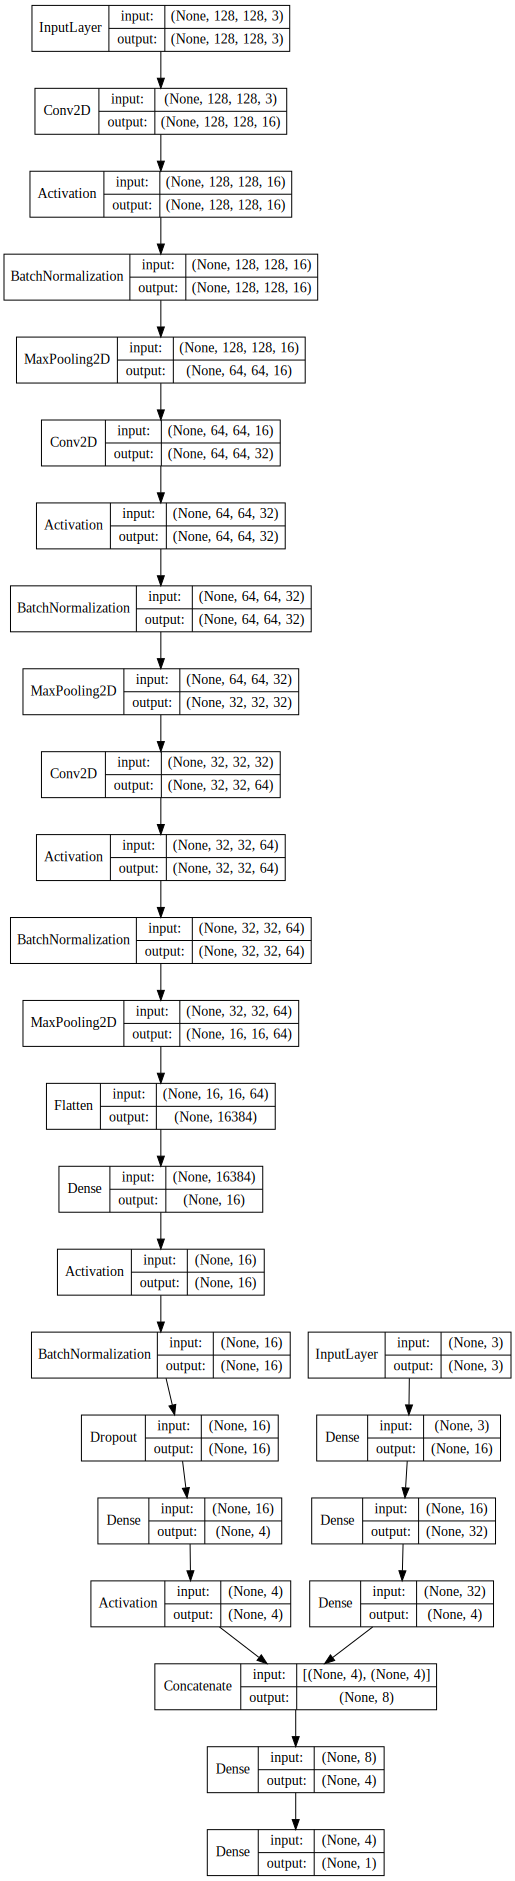

In [92]:
# Visualising the model
SVG(model_to_dot(model2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [93]:
plot_model(model2, to_file='mixed_model4_v2.png')

In [94]:
start = datetime.datetime.now()

# compile the model 
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model2.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=opt)
 
# train the model, and validate with the first 1000 rows of the test set
model2_history = model2.fit([trainAttrX, trainImagesX], trainY, validation_data=([testAttrX[:1000], testImagesX[:1000]], testY[:1000]), epochs=20, batch_size=10)
 
end = datetime.datetime.now()
print("Time taken to run:", end-start)

Train on 15000 samples, validate on 1000 samples
Epoch 1/20
15000/15000 [==============================] - 293s 20ms/step - loss: 2.2626 - acc: 0.6849 - val_loss: 1.9108 - val_acc: 0.7350
Epoch 2/20
15000/15000 [==============================] - 272s 18ms/step - loss: 1.8048 - acc: 0.7400 - val_loss: 1.6438 - val_acc: 0.6660
Epoch 3/20
15000/15000 [==============================] - 257s 17ms/step - loss: 1.7947 - acc: 0.7665 - val_loss: 1.8220 - val_acc: 0.7290
Epoch 4/20
15000/15000 [==============================] - 257s 17ms/step - loss: 1.7091 - acc: 0.7719 - val_loss: 1.4771 - val_acc: 0.7660
Epoch 5/20
15000/15000 [==============================] - 257s 17ms/step - loss: 1.6491 - acc: 0.7761 - val_loss: 1.4635 - val_acc: 0.8030
Epoch 6/20
15000/15000 [==============================] - 260s 17ms/step - loss: 1.6697 - acc: 0.7809 - val_loss: 1.6597 - val_acc: 0.7680
Epoch 7/20
15000/15000 [==============================] - 258s 17ms/step - loss: 1.5104 - acc: 0.7855 - val_loss: 1.2

In [95]:
model2.save('models/mixed_model4_v2.h5')

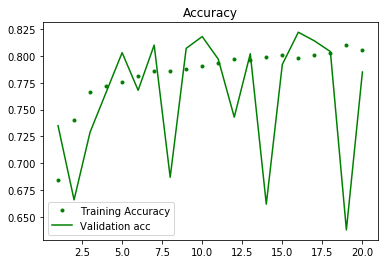

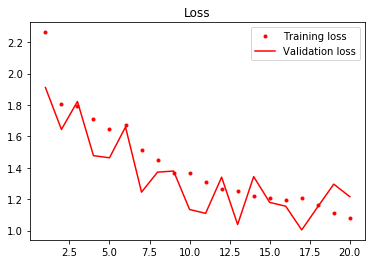

4000/4000 [==============================] - 33s 8ms/step
Test Loss: 1.200561128616333
Test Accuracy: 0.791
              precision    recall  f1-score   support

           0       0.87      0.73      0.80      7476
           1       0.77      0.89      0.83      7524

   micro avg       0.81      0.81      0.81     15000
   macro avg       0.82      0.81      0.81     15000
weighted avg       0.82      0.81      0.81     15000

              precision    recall  f1-score   support

           0       0.86      0.70      0.77      2013
           1       0.74      0.88      0.81      1987

   micro avg       0.79      0.79      0.79      4000
   macro avg       0.80      0.79      0.79      4000
weighted avg       0.80      0.79      0.79      4000



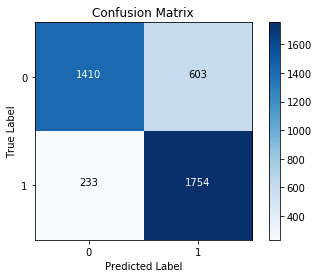

In [96]:
cnn_evaluation(model2, model2_history, trainAttrX, trainImagesX, trainY, testAttrX[1000:], testImagesX[1000:], testY[1000:], class_names=['serious', 'safe'])

This model performs slightly worse than the first version, on the basis of both the F1 score and the recall rate/proportion of false negatives. Therefore, the preferred model is version 1.

## Summary and potential directions for future work

The best model produced was version 1, which had an average F1 score of 0.82 and had no overfitting.

To try and improve the accuracy of the model, some of the following could be tried in further model iterations:
- Increasing the image size for input into the CNN branch
- Using a pre-trained model as the base for the CNN (which increased accuracy in model 2)
- Parameter tuning of both the CNN and MLP components (e.g. experimenting with regularization and optimization)
- Parameter tuning of the final fully-connected layer head
- Adding additional data to the structured dataset about the local area
- Limiting the 'safe square' part of the dataset to only squares that contain roads of some type, i.e. excluding fields, forests and bodies of water